<h1 style="font-size:36px;">Long-Short Term Memory(LSTM)</h1>

LSTM is a type of artificial neural network that can handle long-term dependencies and is especially used for time series data. In Bitcoin price prediction, it is possible to predict future prices by training the LSTM model, taking into account other factors besides past price data.


LSTM, uzun vadeli bağımlılıkları işleyebilen ve özellikle zaman serisi verileri için kullanılan bir tür yapay sinir ağıdır. Bitcoin fiyatı tahmininde, geçmiş fiyat verilerinin yanı sıra diğer faktörleri de dikkate alarak, LSTM modeli eğitilerek gelecekteki fiyatları tahmin etmek mümkündür.

This model includes an LSTM layer, a dropout layer, a dense layer, and an activation layer. The LSTM layer has 100 neurons and contains 42,800 parameters. The dropout layer ensures that each input unit is thrown independently according to the dropout probability during training. The dense layer has 1 output neuron and contains 101 parameters. "Linear" is used as the activation function. The total number of learnable parameters is 42,901 and this model can be used for regression problems. The model is compiled with the "mse" loss function and the "man" optimizer.

Bu model, bir LSTM katmanı, bir dropout katmanı, bir yoğun katman ve bir aktivasyon katmanı içerir. LSTM katmanında 100 nöron vardır ve 42.800 adet parametre içerir. Dropout katmanı, eğitim sırasında her bir giriş biriminin bağımsız olarak dropout olasılığına göre atılmasını sağlar. Yoğun katmanda 1 çıktı nöronu vardır ve 101 adet parametre içerir. Aktivasyon fonksiyonu olarak "linear" kullanılır. Toplam öğrenilebilir parametre sayısı 42.901'dir ve bu model regresyon problemleri için kullanılabilir. Model, "mse" kayıp fonksiyonu ve "adam" optimize edici ile derlenmiştir.


<h3 style="font-size:24px;">Data preprocessing and Preparation</h3>

In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

In [3]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [4]:
target_col = 'close'

In [5]:
hist

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2017-11-29,11417.84,8938.70,9906.04,233325.32,2.418792e+09,9837.86
2017-11-30,10689.06,9023.77,9848.05,187008.87,1.836210e+09,9946.76
2017-12-01,10942.80,9420.93,9947.08,131918.85,1.353670e+09,10861.47
2017-12-02,11175.23,10715.55,10861.47,86825.51,9.504742e+08,10912.73
2017-12-03,11851.09,10578.43,10912.72,122125.70,1.380012e+09,11246.21
...,...,...,...,...,...,...
2023-05-18,27473.95,26394.46,27404.35,27573.46,7.456673e+08,26821.85
2023-05-19,27176.23,26661.47,26821.85,16451.04,4.423047e+08,26887.96
2023-05-20,27163.96,26839.84,26887.96,7364.81,1.987624e+08,27117.18


In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(hist, test_size=0.2)

In [8]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

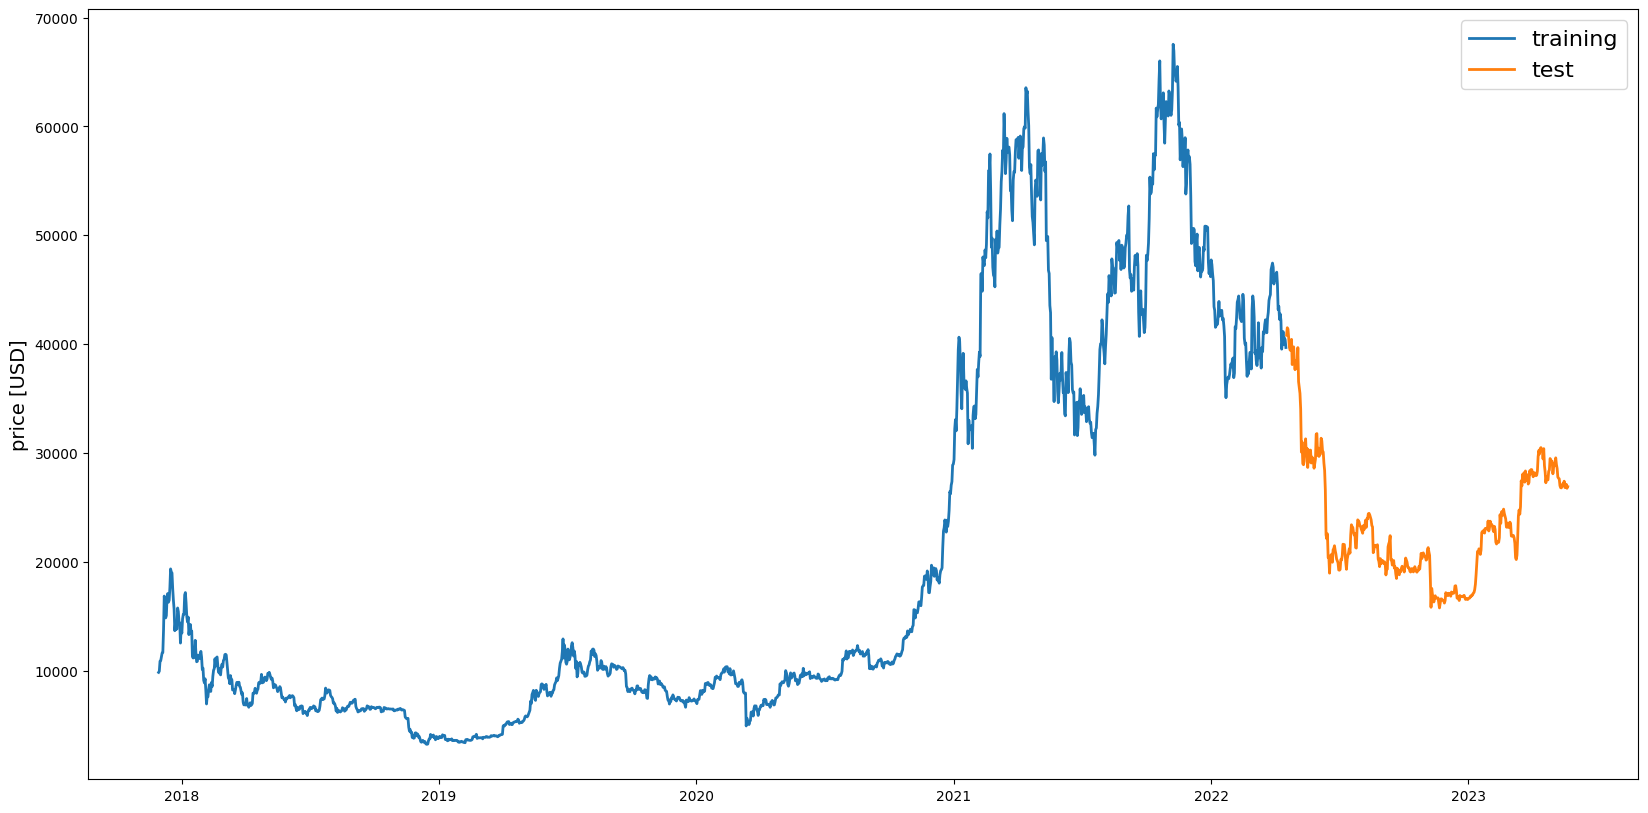

In [9]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [10]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [11]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [12]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [13]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [14]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 60
epochs = 50
batch_size = 32
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [15]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [16]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
57/57 [==============================] - 1s 7ms/step - loss: 0.0607 - val_loss: 0.0271
Epoch 2/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0468 - val_loss: 0.0312
Epoch 3/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0428 - val_loss: 0.0304
Epoch 4/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0408 - val_loss: 0.0196
Epoch 5/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0376 - val_loss: 0.0208
Epoch 6/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0195
Epoch 7/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0208
Epoch 8/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0179
Epoch 9/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0186
Epoch 10/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0189
Epoch 11/50
57/57 [

In [17]:
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                16080     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 16,141
Trainable params: 16,141
Non-trainable params: 0
_________________________________________________________________
None


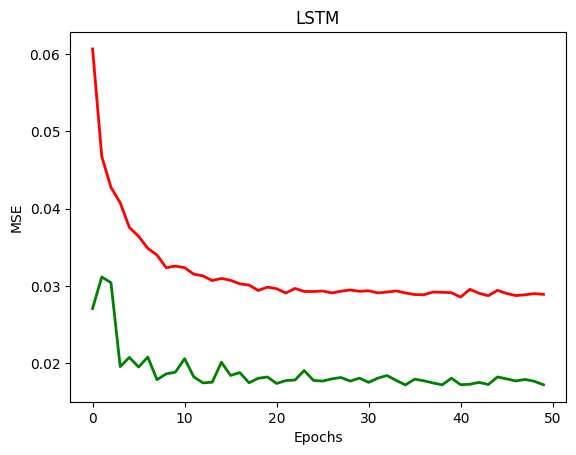

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [19]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()


7/7 [==============================] - 0s 1ms/step


In [20]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE

0.0006476285548572774

In [21]:
RMSE= np.sqrt(MSE)
RMSE

0.025448547205238994

In [22]:
MAE=mean_absolute_error(preds, y_test)
MAE

0.01722665510460987

In [23]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.9039496882606614

In [24]:
import pandas as pd

# Değerleri bir sözlük yapısında sakla
results = {'MSE': [MSE], 'RMSE': [RMSE], 'MAE': [MAE], 'R2': [R2]}

# DataFrame oluştur ve index değerlerini varsayılan değerlerle ata
LSTM_ERROR= pd.DataFrame.from_dict(results, orient='index').T

# DataFrame'i ERROR ismiyle kaydet
LSTM_ERROR = LSTM_ERROR.to_string(index=False)

# ERROR'u yazdır

print(LSTM_ERROR)

     MSE     RMSE      MAE      R2
0.000648 0.025449 0.017227 0.90395


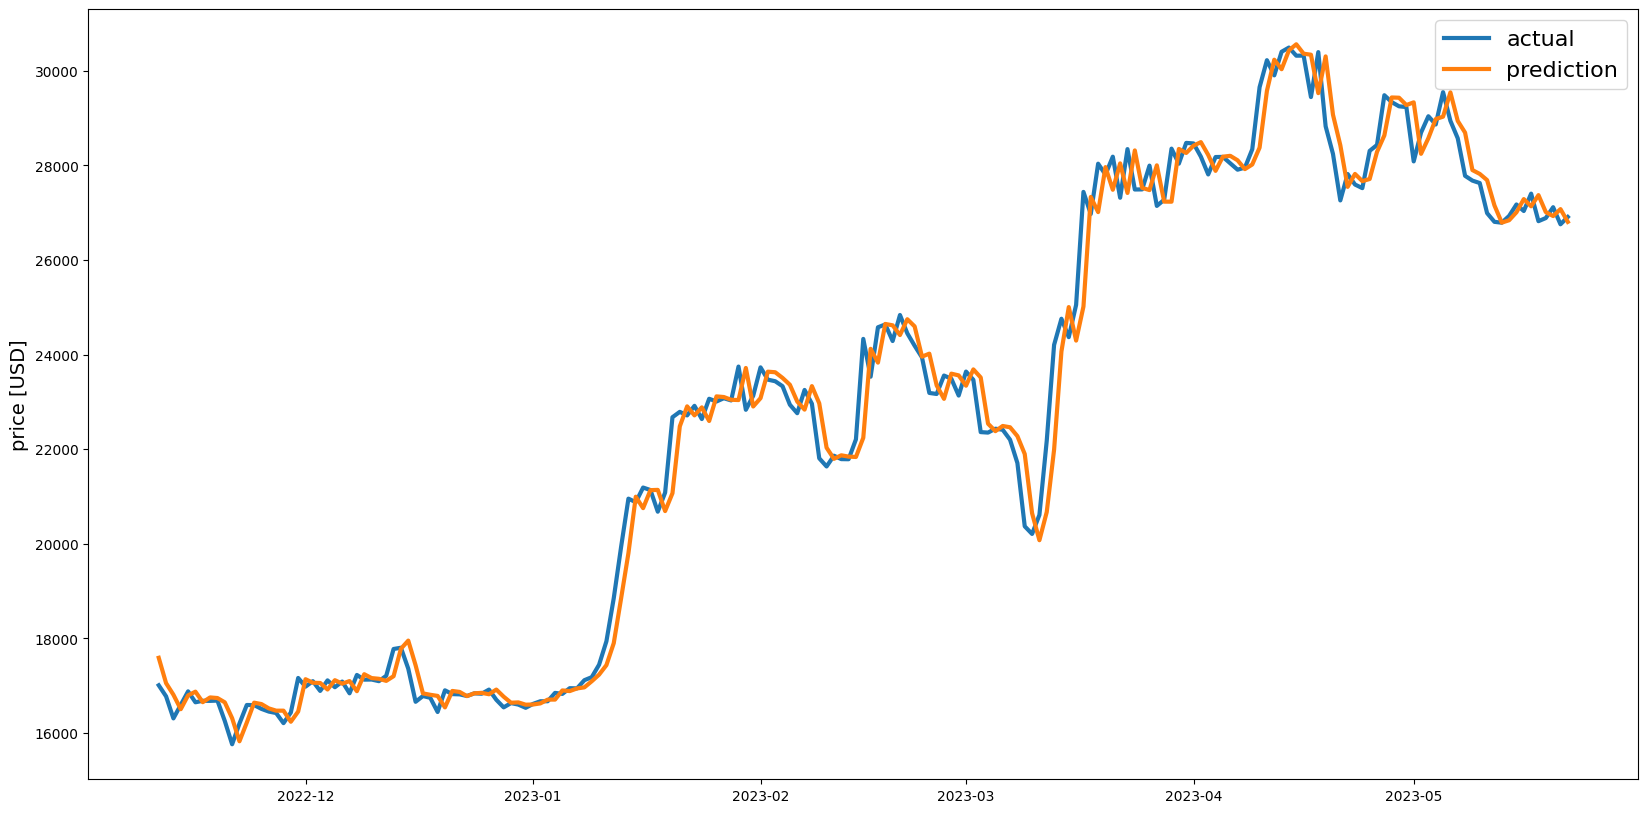

In [25]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [26]:
import pandas as pd

# Değerleri bir sözlük yapısında sakla
results = {'MSE': [MSE], 'RMSE': [RMSE], 'MAE': [MAE], 'R2': [R2]}

# DataFrame oluştur ve index değerlerini varsayılan değerlerle ata
LSTM_ERROR = pd.DataFrame.from_dict(results, orient='index').T

# Çıktıyı metin dosyasına aktar
output_text = LSTM_ERROR.to_string(index=False)

# Metin dosyasını kaydet
with open('LSTM_ERROR.txt', 'w') as file:
    file.write(output_text)
